## NBA Exploratory Analysis -Focus on Bubble Playoffs 2019-20 ##

* * *

**Step 1: Creating a function to automate scraping data from NBA stats with Selenium and pyautogui**

(please note NBA-stats site changes rapidly and this code might be a little off 
by the time you try it)

In [1]:
import toggle_cell 

toggle_cell.hide_solution()

import pandas as pd
from selenium import webdriver      #  selenium should be pip installed
from bs4 import BeautifulSoup as bs
import pyautogui                    #  should be pip installed
import time
import requests 
import os
import xlsxwriter
import matplotlib.pyplot as plt
%matplotlib inline 


#-----------------------------------------scraping finctions ---------------------------------    
def start_scraping():
    while True:    #-- do always  until input is valid
        start_command= input("\nto scrape NBA tables?: (y/n)-------  " )
        
        if start_command == 'y' or start_command == 'n':
            
            break
        else:
            print ("\ninvalid input, try again\n")
    return start_command


      
# the function below needs 4 parameters to work:  webpage's url ,chrome driver's path
# and 2 picture locations of the buttons it presses

def scrape_all_urls (url_list):
    
    for i in range(len(url_list)):
        
        print(f"\nscraping link number {i+1}...\n")
        time.sleep(30)        
        #2:  
        driver_path="C:\\Users\\shpri\\chromedriver\\chromedriver_win32\\chromedriver.exe"
        
        #define the "robot" browser as a chrome browser:
        
        driver = webdriver.Chrome(driver_path)
              
        
        #3: "I Accept".png button location:
        button1= r'C:\Users\shpri\Desktop\scripts\nba_click.png'
        
        #4:  forward arrow (>) .png button location: 
        button2= r'C:\Users\shpri\Desktop\scripts\nba_click2.png'
        
            #load site and find buttons to press:
        center= load_and_locate  (url_list[i], driver, button1, button2)
                 
         
        #iterates seasons:   
        for j in range(len(s_list)):
            
        #the table scraping function:
            df= scrape_nba_stats (url_list[i], driver ,button1 ,button2, j, center)
        # #store df scraped in a dict :    
        #     df_dict[s_list[i]]= df
                
        # create excel file :            
            table_name= url_list[i].split('/')[-2]+'_'+s_list[j]
                
            table_to_excel(table_name ,df)
                
            time.sleep(5)    
            
        # choose next season from drop-down menu with selenium  :
            
            if j <4:
            
                years_drop =10-j  #11-->2015/2016  #10--> 2016/1017 , #9-->2017/2018, #8-->2018/2019, #7-->2019/2020
            
                driver.find_element_by_xpath(f"//select[@name='Season']/option[@value='object:{years_drop}']").click()

                time.sleep(2)
                
                
    
def load_and_locate(url, driver, button1 ,button2 ):
            
    #nevigates to the url- nba stats webpage:
    
    driver.get(url)

    time.sleep(29)
    
    #set chrome driver :
               
    driver.set_window_size(1024, 600)
    
    driver.maximize_window()
    
    time.sleep(20)

# locate and press "I Accept" button to enter the site:
    pyautogui.click(pyautogui.center(pyautogui.locateOnScreen(button1)))
    
    # time.sleep(5)

# #find location of table-nevigation button:
   
    time.sleep(3)
    
    # center=  driver.find_element_by_xpath('/html/body/main/div/div/div[2]/div/div/nba-stat-table/div[1]/div/div/a[2]')
    location= pyautogui.locateOnScreen(button2)
                    
    center= pyautogui.center(location)  
    
    return center


     
def scrape_nba_stats( url ,driver, button1, button2, iter_num ,center ):
    
    #intialize an empty datafame:
    df=pd.DataFrame()
                   
    ############ iterate through web-pages and scrape all the table elements:
     
    ## find pages number with the function below:
    pages= stats_table_pages_lengh(driver)
    
    for i in range(pages):
    
    #get the table html element by finding the XPATH first:
        driver.find_element_by_xpath('/html/body/main/div/div/div[2]/div/div/nba-stat-table/div[2]')

                                      
    #translate HTML to a datafrme:
    
        html=driver.page_source    
    
        df2= pd.read_html(html)[0]
            
    # finally: combine new frame with prevoius table:    
        df= df.append(df2,ignore_index=True)
        
        time.sleep(3)
    # image of button to press:
        pyautogui.click(center)
                 
    return df
 

      
def stats_table_pages_lengh(driver):
    
    time.sleep(5)
    #Xpath to pagination element (pages number) data:
    driver.find_element_by_xpath('/html/body/main/div/div/div[2]/div/div/nba-stat-table/div[1]')
       
                                  
    html=driver.page_source
    
    soup=bs(html,'html.parser')
    
    nevigator =soup.find_all('select',class_="stats-table-pagination__select ng-pristine ng-untouched ng-valid ng-not-empty")
    
    nevigator_str=str(nevigator)

    soup2= bs(nevigator_str, 'html.parser')

    page_num= soup2.find_all('option')[-1].text
    
    return int(page_num)


def table_to_excel(file_name, df):  
          
    data_dir = 'nba_stats_tables'

    if data_dir not in os.listdir():
        os.mkdir(data_dir)  
        
    df.to_excel(f'nba_stats_tables//{file_name}.xlsx')
    
    

**step 2: data exploration ability function**
    
create a pandas function to aggregate all columns by mean and median values when needed

In [2]:
toggle_cell.hide_solution()

def agg_table(df):
    a=[] # columns
    b=[] # names of columns
    for i in range(df.columns.size - 4):
        means= df.iloc[:,i+4].mean() # a column
        medians= df.iloc[:,i+4].median()
        a.extend([means,medians])

        b.extend(['mean '+df.columns[i+4],'median '+df.columns[i+4]])

       
    return pd.Series(a,b)
    

**Step3 : choosing the actual pages to scrape from NBA stats**

after scraping the tables, they where saved as excel files and now we load them into a dictionary
as dataframes 

In [3]:
toggle_cell.hide_solution()

#season we want to scrape:
s_list =['2015-16','2016-17','2017-18','2018-19','2019-20']

start_year= s_list[0]

#links for players stats tables to scrape-:

url1=f'https://nba.com/stats/players/speed-distance/?Season={start_year}&SeasonType=Playoffs'
        
url2=f'https://nba.com/stats/players/traditional/?sort=PTS&dir=-1&Season={start_year}&SeasonType=Playoffs'

url3=f'https://nba.com/stats/players/advanced/?sort=GP&dir=-1&Season={start_year}&SeasonType=Playoffs'

url4=f'https://nba.com/stats/players/drives/?Season={start_year}&SeasonType=Playoffs'

url5=f'https://nba.com/stats/players/clutch-traditional/?sort=GP&dir=-1&Season={start_year}&SeasonType=Playoffs'

url6=f'https://nba.com/stats/players/clutch-advanced/?sort=GP&dir=-1&Season={start_year}&SeasonType=Playoffs'

url7=f'https://www.nba.com/stats/players/scoring/?sort=GP&dir=-1&Season={start_year}&SeasonType=Playoffs'

url8=f'https://www.nba.com/stats/players/traditional/?sort=PTS&dir=-1&Season={start_year}&SeasonType=Playoffs&PerMode=Totals'

url_list= []
   
#user decides if to scrape the above:
scrape_starter= start_scraping() 

url_list.extend([url1,url2,url3,url4,url5,url6,url7,url8])

if scrape_starter == 'y':
 
    scrape_all_urls(url_list) # will create excel file for each season for each table type in link
        
else :
    print ("\nuser decided not to scrape\n")
    
    
################################# retreiving and uniting tables with pandas
# path=  r'C:\Users\shpri\Desktop\Data Science\roy_exe\nba\nba_stats_tables'   
path= 'C:\\Users\\shpri\\Desktop\\Data Science\\roy_exe\\nba'+'\\nba_stats_tables\\'
table_dict= {}
tables=[]

for i in range(len(url_list)) :
    for j in range(len(s_list)):
        tables.append(url_list[i].split('/')[-2]+'_'+s_list[j])
        
del url1,url2,url3,url4,url5,url6,url7,url8
 
for i in tables : 
    table_dict[i]= pd.read_excel(path+i+'.xlsx').dropna(thresh=10, axis=1).assign(year=i[-7:])




to scrape NBA tables?: (y/n)-------  n

user decided not to scrape



**step 4: cleaning the data**
    
First off is getting rid of so called "POSTER-BOYS".  This are players which have unreliable averages, beacuse they scarcely ever play, meaning that they push the general averages up or down falsely .
this will be done by categorizing each player as- "leader", "supporter", "sub" or "poster"
    
Secondly -  we will categorize the players as belonging to a 'winning teams' or 'losing teams' . 
In playoffs situation ,losing teams leave the tournament early-on and have
much less effect on general trends, so their avergaes skew the data the wrong way.
so, we want the ability to get rid of them 

    

we will devide to categories by using the PIE stat:

PIE=  (PTS + FGM + FTM - FGA - FTA + DREB + (.5 * OREB) + AST + STL + (.5 * BLK) - PF - TO) / (GmPTS + GmFGM + GmFTM - GmFGA - GmFTA + GmDREB + (.5 * GmOREB) + GmAST + GmSTL + (.5 * GmBLK) - GmPF - GmTO)
Gm figures correspond to total Game (sum of both teams) figures.

This is a very powerful mesure that takes into account all the important stats in the game and divide them by all the stats achived in a game.
this basically shows the dominance and influence a player has on the game

In [4]:
toggle_cell.hide_solution()


#the players who played in 2020 playoffs:
players_2020= table_dict["advanced_2019-20"]["PLAYER"].values

#the players who played in 2017-2019 playoffs:
past_players= table_dict["advanced_2017-18"].append(table_dict["advanced_2018-19"]  )
advanced_table= table_dict["advanced_2017-18"].append(table_dict["advanced_2018-19"].append(table_dict["advanced_2019-20"])  )

# 142 players played in 2020 and at least one of the 2 last playoffs:
player_list= past_players[past_players["PLAYER"].isin(players_2020)]["PLAYER"].unique()

advanced= advanced_table[ (advanced_table['MIN']>25) ] .sort_values("PLAYER")
advanced_agg= advanced.groupby("PLAYER")['PIE'].mean()

posters_min =advanced_table.groupby("PLAYER")["MIN"].mean()

# pie > 10% is considered by the MBA as high PIE
leaders= list(advanced_agg[advanced_agg>=11].index)
supporters=  list(advanced_agg[advanced_agg<11].index)
posters= list(posters_min[posters_min<5].index)

leaders_table= pd.DataFrame(leaders,columns=['PLAYER']).assign(role='leaders')
supporters_table= pd.DataFrame(supporters,columns=['PLAYER']).assign(role='supportes')
posters_table= pd.DataFrame(posters,columns=['PLAYER']).assign(role='posters')
roles_table= leaders_table.append(supporters_table).append(posters_table)

## join roles - every table needs it:
teams= table_dict["advanced_2019-20"][['PLAYER','TEAM']].set_index("PLAYER")
leaders_table2=roles_table.join(teams ,on='PLAYER')




**step 5: minutes/speed/distance analysis**
 
we start with the basics: 
  how many minutes did every category play on average in the last 3 playoffs?




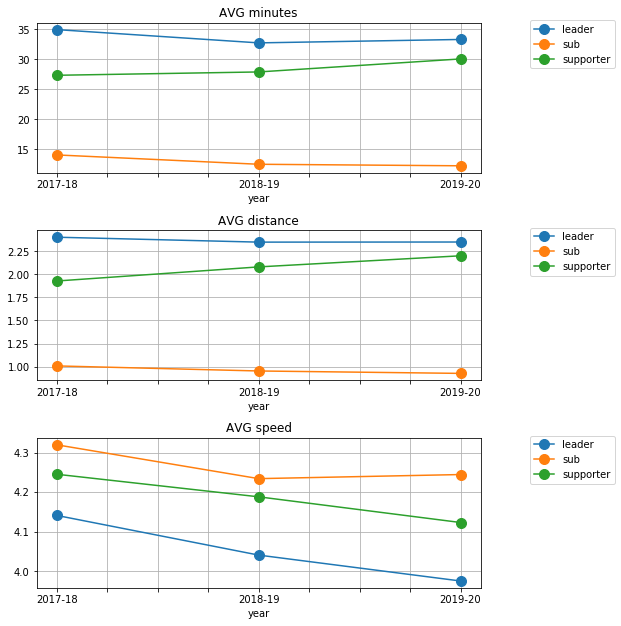

In [5]:
toggle_cell.hide_solution()

past_players2=table_dict["speed-distance_2017-18"].append(table_dict["speed-distance_2018-19"]  )

test_players2= past_players2.append( table_dict["speed-distance_2019-20"]) 

test_players2['Dist.\xa0Feet']= test_players2['Dist.\xa0Feet'].replace('-','0').astype('float64')
test_players2=test_players2.dropna(thresh= 5, axis=1)

# adding a 'class' columns to the table:
test_players2["class"]=test_players2["Player"].apply(lambda x: 'leader' if x in leaders else('supporter' if x in supporters else ('sub' if x not in posters else 'poster')))

leader_2_agg= test_players2.groupby(['year','class']).apply(agg_table).reset_index()
filter_2= leader_2_agg[leader_2_agg['class']!='poster'].set_index(['year','class'])

test_players2["type"]=test_players2["GP"].apply(lambda x: 'winner' if x > 8 else 'loser')

leader_2_agg2= test_players2.groupby(['year','class','type']).apply(agg_table).reset_index()
filter_2_winners= leader_2_agg2[leader_2_agg2['class']!='poster'].set_index(['year','class','type'])


check_role= test_players2[(test_players2['Team']=='LAC') & (test_players2['year']== '2019-20') ]

filter_2_plot_min= filter_2['mean MIN'].unstack()
filter_2_plot_distance= filter_2['mean Dist.\xa0Miles'].unstack()
filter_2_plot_speed= filter_2['mean Avg\xa0Speed'].unstack()

fig = plt.figure(figsize=(8.8,8.8))

# Divide the figure into a 3x1 grid, and give me the first section
ax1 = fig.add_subplot(3,1,1)

# Divide the figure into a 3x1 grid, and give me the second section
ax2 = fig.add_subplot(3,1,2)

# Divide the figure into a 3x1 grid, and give me the third section
ax3 = fig.add_subplot(3,1,3)

# plot 1: checking minutes, speed and distance between roles over years:

filter_2_plot_min.plot(kind= 'line',ax=ax1, marker= 'o', markersize= 10, title= 'AVG minutes' , grid= 'True' )


filter_2_plot_distance.plot(kind= 'line',ax=ax2, marker= 'o', markersize= 10, title= 'AVG distance', grid=True)


filter_2_plot_speed.plot(kind= 'line',ax=ax3, marker= 'o', markersize= 10, title= 'AVG speed', grid= True)

ax1.legend(bbox_to_anchor=(1.1, 1.05))
ax2.legend(bbox_to_anchor=(1.1, 1.05))
ax3.legend(bbox_to_anchor=(1.1, 1.05))

           
plt.tight_layout()



based on this plot, Supporters seems to have more minutes and run more distance in 2020,
so we will want to focus our anlaysis on supporters 

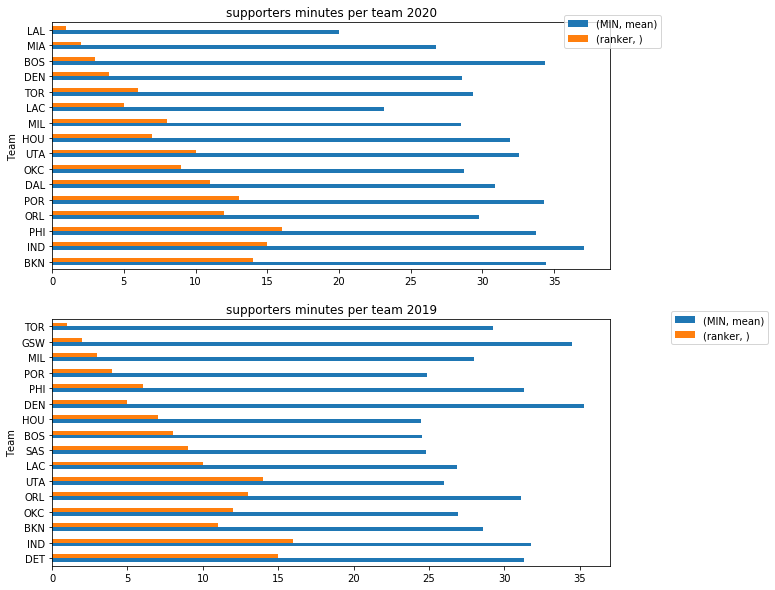

In [6]:
toggle_cell.hide_solution()

fig= plt.figure(figsize=(10,10))
# supporters in teams:

ax4 = fig.add_subplot(2,1,1)
ax5 = fig.add_subplot(2,1,2)

#2019-20:
test_players2_teams= test_players2[(test_players2['year']== '2019-20') & (test_players2['class'] == 'supporter')]
per_team= test_players2_teams.groupby('Team').agg({'MIN':['mean'],'W':['max']}).sort_values(('W','max'),ascending=True)

per_team['ranker']=per_team['W'].rank(method='first', ascending=False)

per_team1=  pd.DataFrame(per_team.loc[ :,('MIN','mean')]).join(pd.DataFrame(per_team.loc[ :,('ranker','')]))

# plot2: shows teams and supporters minutes:
ax_barh1= per_team1.plot(kind='barh', ax=ax4 , title='supporters minutes per team 2020')

#2018-2019:
test_players2_teams= test_players2[(test_players2['year']== '2018-19') & (test_players2['class'] == 'supporter')]
per_team= test_players2_teams.groupby('Team').agg({'MIN':['mean'],'W':['max']}).sort_values(('W','max'),ascending=True)

per_team['ranker']=per_team['W'].rank(method='first', ascending=False)

per_team2=  pd.DataFrame(per_team.loc[ :,('MIN','mean')]).join(pd.DataFrame(per_team.loc[ :,('ranker','')]))

# plot2: shows teams and supporters minutes:
ax_barh2= per_team2.plot(kind='barh',ax=ax5, title='supporters minutes per team 2019')

ax_barh1.legend(bbox_to_anchor=(1.1, 1.05))
ax_barh2.legend(bbox_to_anchor=(1.1, 1.05))

plt.show()



so now we can actually see that winning teams (high ranked) don't use supporters as much as 
losing teams.  supporters receive more minutes on average but not as a winning or influential trend in 2020

**from here on we will look mainly on winning teams to understand better the trends of this playoffs**

*  *  *

**step 6 : Advanced stats analysis (PIE, AST/TO ,USG% vs TS%)**  :

moving on to the advanced stats table -

we will draw 3 PIE bar plots for it's analysis (it used to be a 3 PIE-pie charts, before a strict diet..), each plot focuses on a category along the 3 years span ,hence 3 bars per plot: 

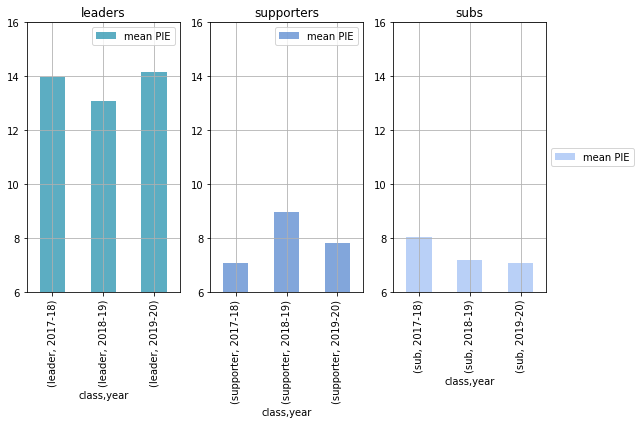

In [7]:
toggle_cell.hide_solution()

%matplotlib inline
#the players who played in 2016-2019 playoffs:
past_players1= table_dict["advanced_2017-18"].append(table_dict["advanced_2018-19"]  )

test_players1= table_dict["advanced_2019-20"].append(past_players1)

leader_1= test_players1[test_players1['PLAYER'].isin(leaders)]

table1= test_players1.groupby(['year']).apply(agg_table)

# adding class:

test_players1["class"]=test_players1["PLAYER"].apply(lambda x: 'leader' if x in leaders else('supporter' if x in supporters else ('sub' if x not in posters else 'poster')))

leader_1_agg= test_players1.groupby(['year','class']).apply(agg_table).reset_index()

# filtering by class:

filter_1= leader_1_agg[leader_1_agg['class']!='poster'].set_index(['year','class'])

# adding type:

test_players1["type"]=test_players1["GP"].apply(lambda x: 'winner' if x > 8 else 'loser')

leader_1_agg2= test_players1.groupby(['year','class','type']).apply(agg_table).reset_index()

# filter for winning players:

filter_1_winners= leader_1_agg2[leader_1_agg2['class']!='poster'].set_index(['year','class','type'])

filter_1_winners=(filter_1_winners.reset_index() [filter_1_winners.reset_index()['type']== 'winner' ]).set_index(['year','class','type'])

filter_1_winners_leaders= filter_1_winners.loc[[x for x in filter_1_winners.index if x[1]=='leader']]
filter_1_winners_supporters= filter_1_winners.loc[[x for x in filter_1_winners.index if x[1]=='supporter']]
filter_1_winners_subs= filter_1_winners.loc[[x for x in filter_1_winners.index if x[1]=='sub']]

# plotting..
#  PIE= (PTS + FGM + FTM - FGA - FTA + DREB + (.5 * OREB) + AST + STL + (.5 * BLK) - PF - TO) / (GmPTS + GmFGM + GmFTM - GmFGA - GmFTA + GmDREB + (.5 * GmOREB) + GmAST + GmSTL + (.5 * GmBLK) - GmPF - GmTO)
fig = plt.figure(figsize=(9,6))


ax1=fig.add_subplot(1,3,1)
ax2=fig.add_subplot(1,3,2)
ax3=fig.add_subplot(1,3,3)


pie_plot1= filter_1_winners_leaders.reset_index()[['mean PIE','class','year']].set_index(['class', 'year']).plot(kind='bar',ylim= ((6,16)), subplots=True, ax=ax1, color=(0.2, 0.6, 0.7, 0.8), grid= True)

pie_plot2= filter_1_winners_supporters.reset_index()[['mean PIE','class','year']].set_index(['class','year']).plot(kind='bar',ylim=((6,16)), subplots=True, ax=ax2 , color=(0.3, 0.5, 0.8, 0.7), grid= True)

pie_plot3= filter_1_winners_subs.reset_index()[['mean PIE','class','year']].set_index(['class','year']).plot(kind='bar', ylim=((6,16)), subplots=True, ax=ax3, color=(0.1, 0.4, 0.9, 0.3), grid= True)

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

ax1.set_title('leaders')
ax2.set_title('supporters')
ax3.set_title('subs')

plt.tight_layout()

plt.show()


now we can see the trend for each year much better:

**2018** - leaders and subs year; they are the dominant force

**2019** - subs and supporters year; they provide a unique contribution.

**2020** - the leaders year; the supporters and subs seem to be on a relative low point.

we will try and focus on the leaders of 2020 to see if this assumption sticks or is half-baked....

* * *

**Step 7 : handle of the ball**

first we will look at assists to turnovers ratio  (AST/TO) over the years in winning teams

this will be done for every category :

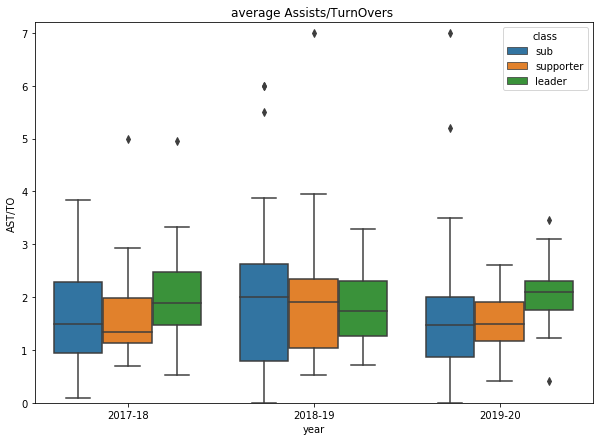

In [8]:
toggle_cell.hide_solution()
import seaborn as sns
%matplotlib inline
fig= plt.figure(figsize=(10,7))

test_players1_ast2= test_players1[ (test_players1['type']=='winner') & (test_players1['class']!='poster')] [['PLAYER','year','AST/TO','class','type']]
plt.ylim([0,7.2])

ax_box= sns.boxplot(data=test_players1_ast2, x='year' , y='AST/TO' , hue='class' , order=["2017-18", "2018-19", "2019-20"]).set_title("average Assists/TurnOvers ")



plt.show()


we can clearly see a narrower distribution is 2020 on higher average

conclusion: 2020 saw more leaders with better control of the game

this fits with the general notion that we concluded from the PIE bar-plot

also we see supporters state much lower in relation to leaders in 2020


*  *  *


**step 8 : focus on leaders**

now we want to make sure leaders' dominance is the crucial difference in 2020 

so we will look at leaders usage% over the years :


In [9]:
toggle_cell.hide_solution()

import decimal

# adding types to the aggregate:
leader_1_agg2= test_players1.groupby(['year','class','type']).apply(agg_table).reset_index()
filter_1_winners= leader_1_agg2[leader_1_agg2['class']!='poster'].set_index(['year','class','type'])

filter_1_winners=(filter_1_winners.reset_index() [filter_1_winners.reset_index()['type']== 'winner' ]).set_index(['year','class','type'])
filter_1_winners_leaders= filter_1_winners.loc[[x for x in filter_1_winners.index if x[1]=='leader']]

filter_1_winners_leaders[['mean USG%','median USG%','mean PACE']]=filter_1_winners_leaders[['mean USG%','median USG%','mean PACE']].applymap( lambda x: round(decimal.Decimal(x),3)   )

filter_1_winners_leaders[['mean USG%','median USG%','mean PACE']].style.background_gradient(cmap='Blues')

,,,mean USG%,median USG%,mean PACE
year,class,type,,,
2017-18,leader,winner,23.748,23.000,97.993
2018-19,leader,winner,22.763,20.900,98.753
2019-20,leader,winner,24.780,24.900,98.708



so it's clearly going up in 2020 

high USG% means egotistical style of play-  a player takes the ball to the basket more often in his 
possessions.

on the other hand - we can see this year is not unique in PACE, meaning it has similiar amount of 

possessions on average, so this could have lead to higher precentage of poor shooting desicions.


we can check this by looking at True-shooting value (precentage of scoring) distribution :


In [10]:
toggle_cell.hide_solution()
import mpld3  # must be pip installed for intercative display

%matplotlib inline

fig= plt.figure(figsize=(10,7))

test_players1_usg= test_players1[(test_players1['class']=='leader') & (test_players1['type']=='winner')]
                                  
ax= sns.jointplot('USG%','TS%',test_players1_usg, kind='kde')
 
labels= test_players1_usg["PLAYER"].values

tooltip = mpld3.plugins.PointLabelTooltip(ax, labels=labels)

mpld3.plugins.connect(fig, tooltip)

mpld3.display()

<Figure size 720x504 with 0 Axes>

looking at the result of a joint distribution plot:  true-shooting vs usg% plot for leaders 

it shows no connection between higher USG% and poor shooting

on the contrary : it seems more players have higher true-shooting when the usage is high

so this means great efficency.

* * * 

**step 9:**   deffense vs offence

this is the time to check leaders general abilites in the offence and deffence departments.

we will draw a layered bar-plot of deffensive rating VS offensive rating,

in which subs are layered over supporters and they are also layerd over the leaders stats:



**defensive rating**- right bars-  show how much points the opponent scored vs. a player in 100 possessions 

(so this means - low defensive rating equals higher defensive abilities)

**offensive rating**- left bars-  show how much points the player scored vs. the oppenent in  100 possessions





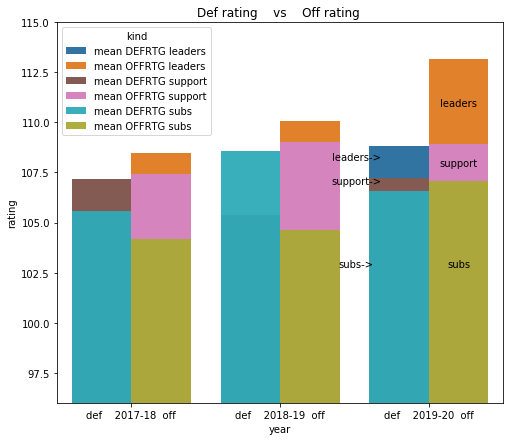

In [11]:
toggle_cell.hide_solution()
import warnings
import seaborn as sns
%matplotlib inline

warnings.filterwarnings('ignore')

fig= plt.figure(figsize=(8,7))


filter_1= leader_1_agg[leader_1_agg['class']!='poster'].set_index(['class','year'])


filter_1.columns

filter1_rating= filter_1_winners[['mean DEFRTG','mean OFFRTG']]


filter1_rating_plot= filter1_rating.stack().reset_index()
filter1_rating_plot['year']= filter1_rating_plot['year'].apply(lambda x:'def    '+x+'  off')

filter1_rating_plot.columns= ['year', 'class', 'type', 'kind', 'rating']

filter1_rating_plot_leaders=filter1_rating_plot [ filter1_rating_plot['class']=='leader' ]

filter1_rating_plot_support=filter1_rating_plot[filter1_rating_plot['class']=='supporter']
filter1_rating_plot_subs   =filter1_rating_plot[filter1_rating_plot['class']=='sub']

filter1_rating_plot_leaders['kind']=filter1_rating_plot_leaders['kind']+' '+'leaders'

filter1_rating_plot_support['kind']=filter1_rating_plot_support['kind']+' '+'support'

filter1_rating_plot_subs['kind']=filter1_rating_plot_subs['kind']+' '+'subs'

plt.ylim((96,115))

ax= sns.barplot( x="year", y="rating", hue="kind", data=filter1_rating_plot_leaders, ci=None, palette=["C0", "C11", "C3"])
sns.barplot( x="year", y="rating", hue="kind", data=filter1_rating_plot_support, ci=None, palette=["C5", "C6", "C2"]).set_title("Def rating    vs    Off rating ")
sns.barplot(x="year", y="rating", hue="kind", data=filter1_rating_plot_subs, ci=None, palette=["C9", "C8", "C4"], alpha=0.95)


# adding text annotation on the plot:
height1 = ax.patches[2].get_height()-1.5
width1= ax.patches[2].get_width()/2 +0.12

height2 = ax.patches[2].get_height()-3.7
width2= ax.patches[2].get_width()/2 -0.29

height3 = ax.patches[2].get_height()-4.9
width3= ax.patches[2].get_width()/2 -0.29

height4 = ax.patches[2].get_height()-4.0
width4= ax.patches[2].get_width()/2 +0.4

height5 = ax.patches[2].get_height()-9.0
width5= ax.patches[2].get_width()/2 -0.29

height6 = ax.patches[2].get_height()-9.0
width6= ax.patches[2].get_width()/2 +0.4
 
height7 = ax.patches[2].get_height()-1.0
width7= ax.patches[2].get_width()/2 +0.4

ax.text(ax.patches[2].get_x()+width2, height2 + 3,'leaders->'
                        ,ha='center')


ax.text(ax.patches[2].get_x()+width3, height3 + 3,'support->'
                        ,ha='center')


ax.text(ax.patches[2].get_x()+width4, height4 + 3,'support'
                        ,ha='center')

ax.text(ax.patches[2].get_x()+width5, height5 + 3,'subs->'
                        ,ha='center')

ax.text(ax.patches[2].get_x()+width6, height6 + 3,'subs'
                        ,ha='center')

ax.text(ax.patches[2].get_x()+width7, height7 + 3,'leaders'
                        ,ha='center')

plt.show()




**on the defensive end**-  (left bars) - dark blue is the indicaor for leaders rating, and we see it 
in 2020 season only , meaning that leaders had the **worst** defense out of all the 3 categories..
also the bar itself is the highest- so this season was the worst defensive year in the last 3 playoffs.
               

**on the offensive end**- (right bars)- orange is the indicator for leaders and we see it best at 2020, , also this year's bar is prominently higher than the rest, so the story this is year was offence.
    
          
                    
          
      

          
       

* * * 

**Final step** - can we tell who are the outliers?

we will try to be a bit pretentious, and draw a PCA scatter plot for all the stats in the advanced 
stats table, for the leaders class.

PCA transformes a multi-dimentional variable situation into a **linear combination** of 2 (or more) 

primary variance components .

so, in simple words, each player will be shown on a new set of axes by how much it contributes to the variance.

we expect players with unusual statistics to be as far as possible from the middle, which is

"the average leader".

the colors represents years, and size represent the distance from the middle point:




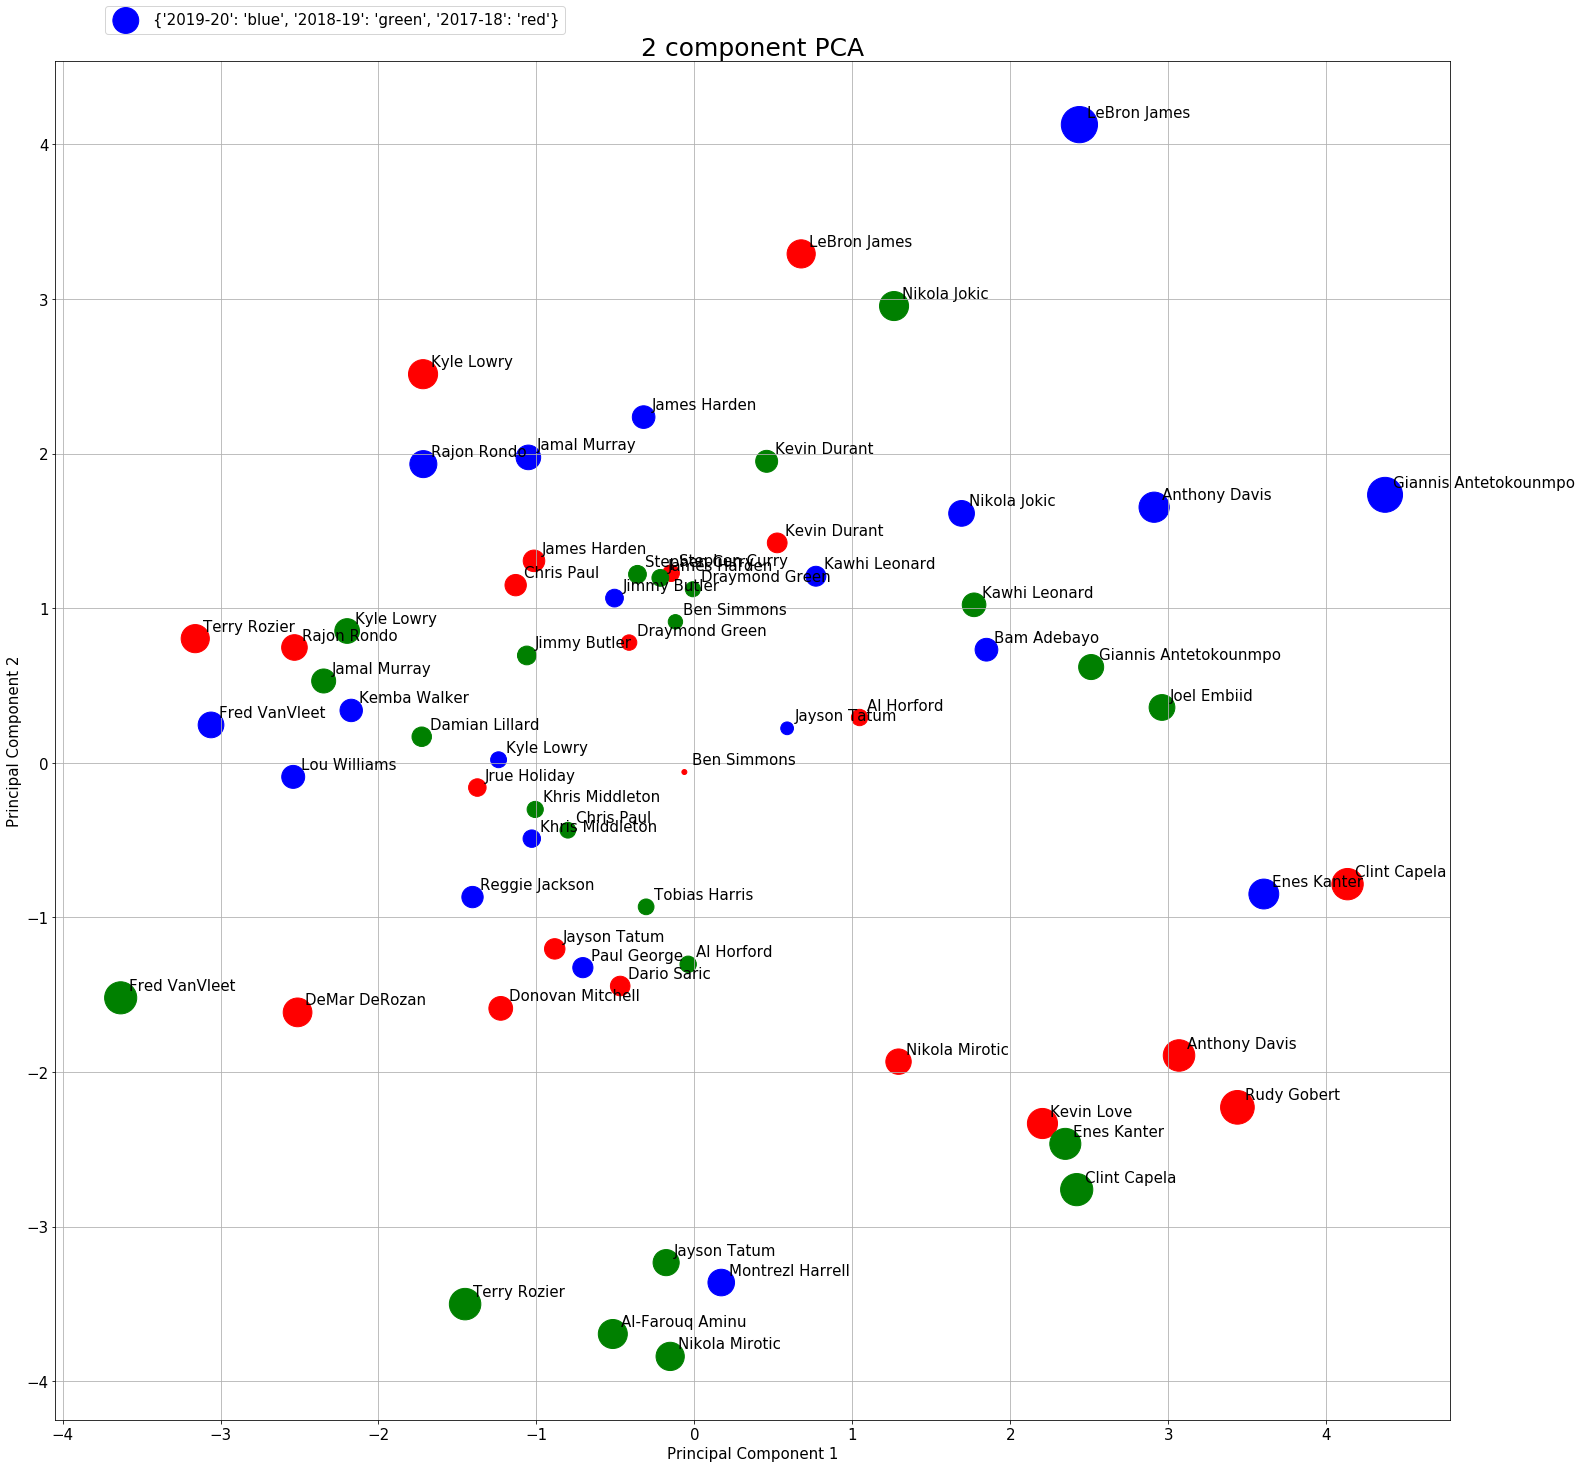

array([0.23227737, 0.20440407])

In [12]:
toggle_cell.hide_solution()
%matplotlib inline
import numpy as np


past_players1= table_dict["advanced_2017-18"].append(table_dict["advanced_2018-19"]  )

test_players1= table_dict["advanced_2019-20"].append(past_players1)


test_players1["type"]=test_players1["GP"].apply(lambda x: 'winner' if x > 8 else 'loser')


leader_1= test_players1[test_players1['PLAYER'].isin(leaders)]
leader_1.columns= leader_1.columns.str.replace('\xa0','')
leader_1.columns

leader_1= leader_1[leader_1['type']=='winner']



leader_1.loc[:,['DEFRTG','NETRTG']]

from sklearn.preprocessing import StandardScaler

features = ['OFFRTG', 'DEFRTG', 'NETRTG', 'AST%', 'AST/TO', 'ASTRatio',
       'OREB%', 'DREB%', 'REB%', 'TORatio', 'eFG%', 'TS%', 'USG%', 'PACE',
       'PIE']

# Separating out the features
x = leader_1.loc[:, features].values
# Separating out the target
y = leader_1.loc[:,['year']].values
# Standardizing the features
x = StandardScaler().fit_transform(x)


from sklearn.decomposition import PCA

pca = PCA(n_components=2,)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame (data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

finalDf_PCA = leader_1['year'].reset_index().join( principalDf)
finalDf_PCA=finalDf_PCA.drop(["index"],axis=1)

# finalDf_PCA.plot(x='principal component 1', y='principal component 2',  kind='scatter')


fig = plt.figure(figsize = (25,25))
plt.rcParams['font.size'] = 15.0

ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 25)

#colors = ['r', 'g', 'b']

colors = { '2019-20':'blue', '2018-19':'green', '2017-18':'red' }

sizes=[]
for i in range(len(finalDf_PCA['principal component 1'])):
    sizes.append ( abs(finalDf_PCA['principal component 1'].values[i])+abs(finalDf_PCA['principal component 2'].values[i]) )
sizes= np.array(sizes)*200

l=['2019-20','2018-19','2019-20']

plt.scatter( x=  finalDf_PCA['principal component 1'],
               y= finalDf_PCA['principal component 2'],
           c=finalDf_PCA['year'].apply(lambda x: colors[x]),
                s = sizes, label=colors)


plt.legend(loc='center left', bbox_to_anchor=(0.03, 1.03))

ax.grid()

n= leader_1["PLAYER"].values

xx=list(finalDf_PCA['principal component 1'].values)
yy=list(finalDf_PCA['principal component 2'].values)
labels= list(leader_1['PLAYER'].values)

for i in range(len(xx))  :                       
    ax.annotate( labels[i] ,xy=(xx[i], yy[i]), xytext=(xx[i]+0.05, yy[i]+0.05) )


plt.show()

pca.explained_variance_ratio_

so we can see that exceptional players (like Lebron James) are indeed very far from the middle, in  the upper half. This is also true to exceptionally "bad" leaders - all on the botoom half of the plot.

also- if you look carefully this time- although we didn't get a seperation between years at all, we do see a nice seperation by positions on the court;  

one might even say that players end-up in clusters by their role and kind of stats that they excell at. 
but only the ones that excel at everything will end up alone in the right upper corner- the MVP corner?

---

**conclusion** : 
our study suggest that the playoffs this year were all about leading players and 
their offence.  
being locked together for 3 months in a bubble did not lead to a more team-oriented style ,
nor did it cripple their efficency in offence. In fact, it was unusually high---
maybe beacuse of the extended rests, or maybe beacuse of lack of interruption (by the fans and media and whatnot),
just like a good student will excel in a big assignmnent.








---
**links**:

TS% - true shooting explained : https://squared2020.com/2017/10/10/relationship-between-ts-and-efg/

DEFRTG & OFFRTG , %USG and more explained- https://bleacherreport.com/articles/1040309-understanding-the-nba-explaining-advanced-defensive-stats-and-metrics

PCA explained:  https://datascienceplus.com/principal-component-analysis-pca-with-python/
    

About the 2020 playoffs Bubble :https://en.wikipedia.org/wiki/2020_NBA_Bubble